<a href="https://colab.research.google.com/github/tkhabia/Fake_USA_news_Detection/blob/master/fake_news_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fake News detection 

In [ ]:
!pip install nltk 
!pip install bert-for-tf2

     |████████████████████████████████| 40kB 2.5MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.5-cp36-none-any.whl size=30315 sha256=0aab0b8d23f961aec5a88d9eed77051eb2901ccc689856be27dcffcc0f72399b
  Stored in directory: /root/.cache/pip/wheels/2e/70/a2/be357037dd2cbdcaeb0add1fdf083be6a600ca65ee1f68751c
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7302 sha256=d1ddc42f4aab759673c291cc9c91b1ddcfeffba13f017cd0129ac184029f262c
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19473 sha256=0980c089bc25ff7e7d4ca19a5dd72a0b17091ae4b01d0f69bc487bd57cf2ddd2
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
nltk.download('stopwords')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
%mkdir drive/My\ Drive/fakeTrueNews
%cp True.csv Fake.csv drive/My\ Drive/fakeTrueNews

In [ ]:
trueNews = pd.read_csv('/content/drive/My Drive/fakeTrueNews/True.csv')
fakeNews = pd.read_csv('/content/drive/My Drive/fakeTrueNews/Fake.csv')

In [ ]:
trueNews['category'] = 1
fakeNews['category']= 0 

# A look at the dataset

In [ ]:
trueNews.head(7)

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
5,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",politicsNews,"December 29, 2017",1
6,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,"December 29, 2017",1


In [ ]:
fakeNews.head(7)

,title,text,subject,date,category
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",0
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017",0


In [ ]:
df = pd.concat([trueNews,fakeNews])

In [ ]:
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

[Text(0, 0, 'politicsNews'),
 Text(0, 0, 'worldnews'),
 Text(0, 0, 'News'),
 Text(0, 0, 'politics'),
 Text(0, 0, 'Government News'),
 Text(0, 0, 'left-news'),
 Text(0, 0, 'US_News'),
 Text(0, 0, 'Middle-east')]

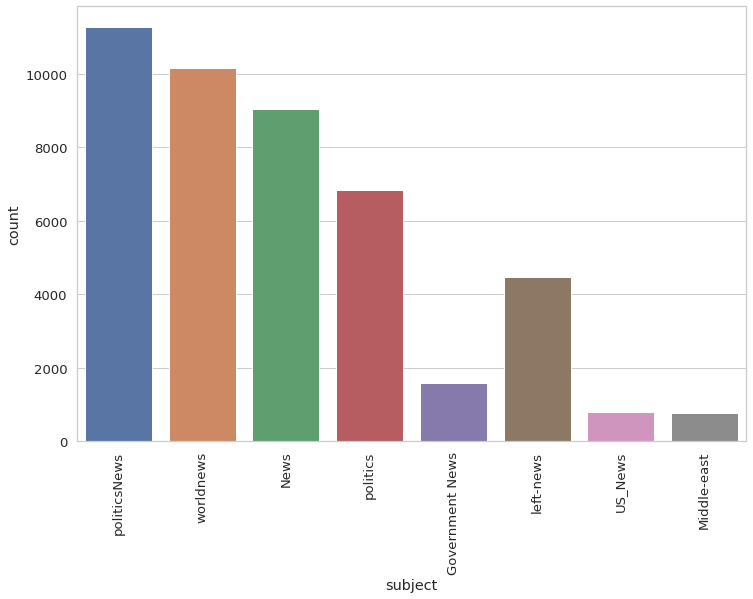

In [ ]:
plt.figure(figsize = (12,8))
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x = "subject" , data = df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

In [ ]:
df.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [ ]:
df['text'] = df['title']  + " " + df['text']
del df['title']
del df['date']
del df['subject']

# Data cleaning 

In [ ]:
def remove_html_elements(text):
  soup = BeautifulSoup(text, "html.parser")
  return soup.get_text()

stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)
def remove_stopwords(text):

  final_text = []
  for i in text.split():
    if i.strip().lower() not in stop:
      final_text.append(i.strip())
  return " ".join(final_text)

def clean_text(text):
  text = remove_html_elements(text)
  text = re.sub('\[[^]]*\]', '', text)
  text = re.sub('http\S+' , '' , text)
  
  text = remove_stopwords(text)
  return text

In [ ]:
df['text'] = df['text'].apply(clean_text)

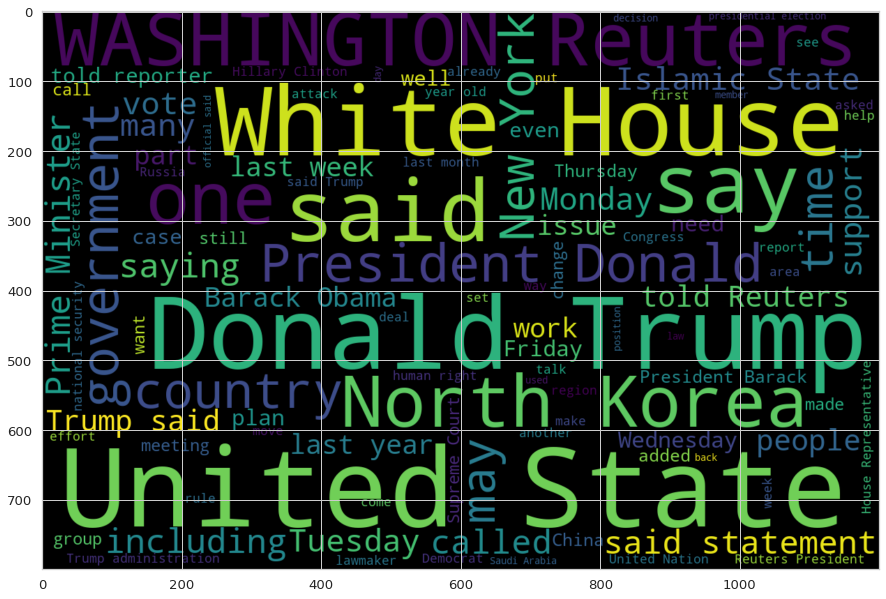

In [ ]:
plt.figure(figsize = (15,15)) # Text that is not Fake
wc = WordCloud(max_words = 100 , width = 1200 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

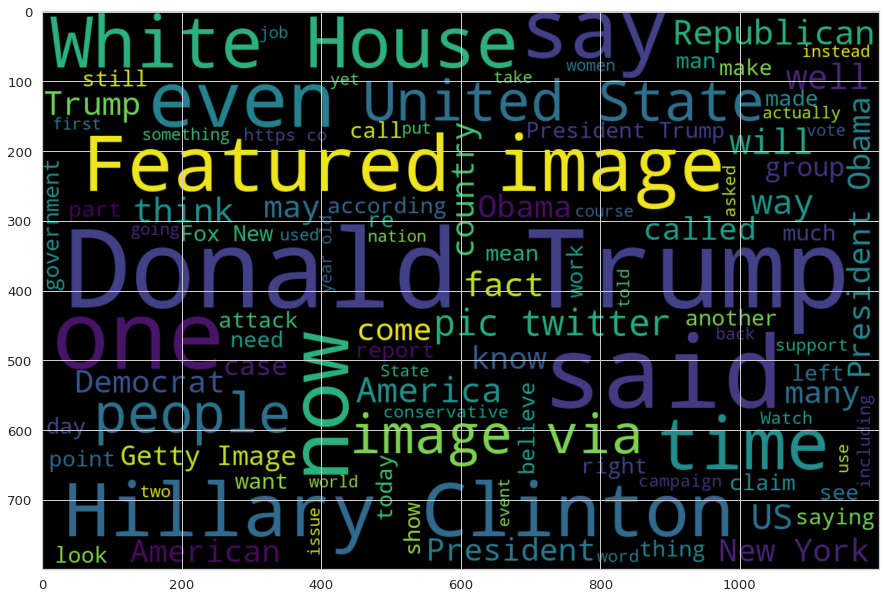

In [ ]:
plt.figure(figsize = (15,15)) # Text that is not Fake
wc = WordCloud(max_words = 100 , width = 1200 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

# Pre Processing 

Splitting the data into test and train

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['category'] , test_size=0.15 , random_state=18)

In [ ]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(df['text'])

Tokenizing the text. It convert the text into a vector which can be trained by our model.

In [ ]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Padding the sequence so all article are of same length.

In [ ]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=500)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=500)

# Building the model. 
- 2 layers of bidirectional LSTM to make model robust
- 2 dense layer to make better decision making, 
- 1 Dropout to prevent overfitting

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6

If model is not improving then stop running epoch.

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


In [ ]:
%%time
history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=64, shuffle=True, callbacks=[early_stop])

Epoch 1/10
537/537 [==============================] - 43s 80ms/step - loss: 0.6082 - accuracy: 0.7799 - val_loss: 0.5132 - val_accuracy: 0.9872
Epoch 2/10
537/537 [==============================] - 41s 77ms/step - loss: 0.5171 - accuracy: 0.9916 - val_loss: 0.5098 - val_accuracy: 0.9929
Epoch 3/10
537/537 [==============================] - 41s 77ms/step - loss: 0.5146 - accuracy: 0.9960 - val_loss: 0.5089 - val_accuracy: 0.9955
Epoch 4/10
537/537 [==============================] - 41s 77ms/step - loss: 0.5142 - accuracy: 0.9966 - val_loss: 0.5090 - val_accuracy: 0.9942
Epoch 5/10
537/537 [==============================] - 41s 77ms/step - loss: 0.5140 - accuracy: 0.9972 - val_loss: 0.5083 - val_accuracy: 0.9963
Epoch 6/10
537/537 [==============================] - 41s 77ms/step - loss: 0.5134 - accuracy: 0.9983 - val_loss: 0.5082 - val_accuracy: 0.9966
Epoch 7/10
537/537 [==============================] - 42s 77ms/step - loss: 0.5136 - accuracy: 0.9979 - val_loss: 0.5083 - val_accuracy:

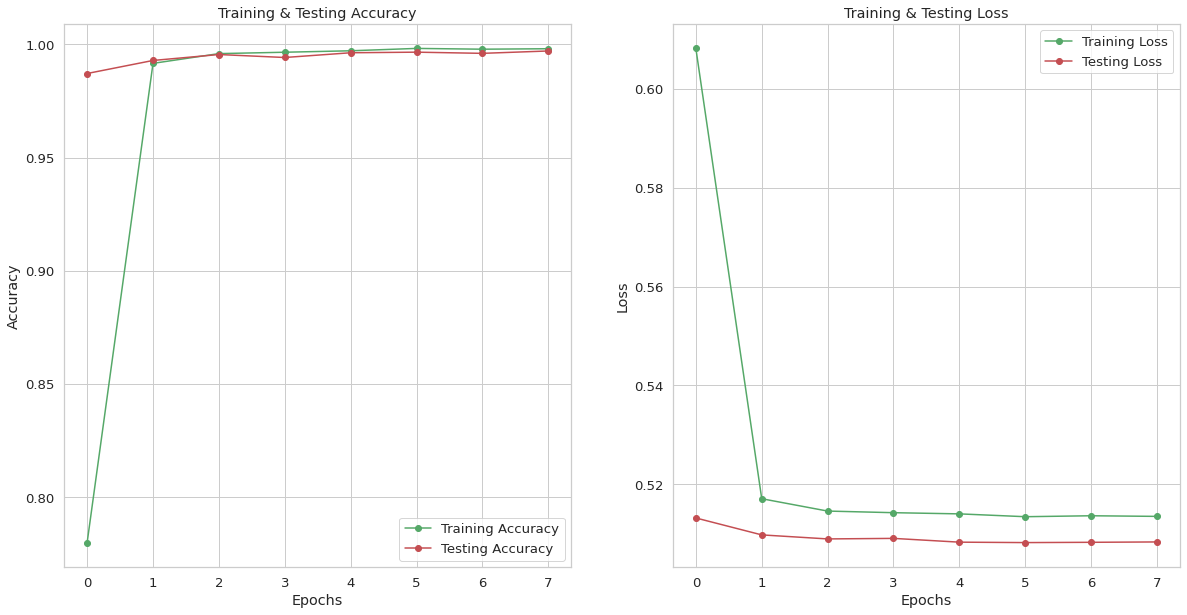

In [ ]:
epochs = [i for i in range(8)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

# Testing the model

In [ ]:
pred = model.predict_classes(X_test)

binary_predictions = []

for i in pred:
  if i >= 0.5:
    binary_predictions.append(1)
  else:
    binary_predictions.append(0) 

print(classification_report(y_test, binary_predictions, target_names = ['Fake','Not Fake']))     

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      3521
    Not Fake       1.00      1.00      1.00      3214

    accuracy                           1.00      6735
   macro avg       1.00      1.00      1.00      6735
weighted avg       1.00      1.00      1.00      6735



[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

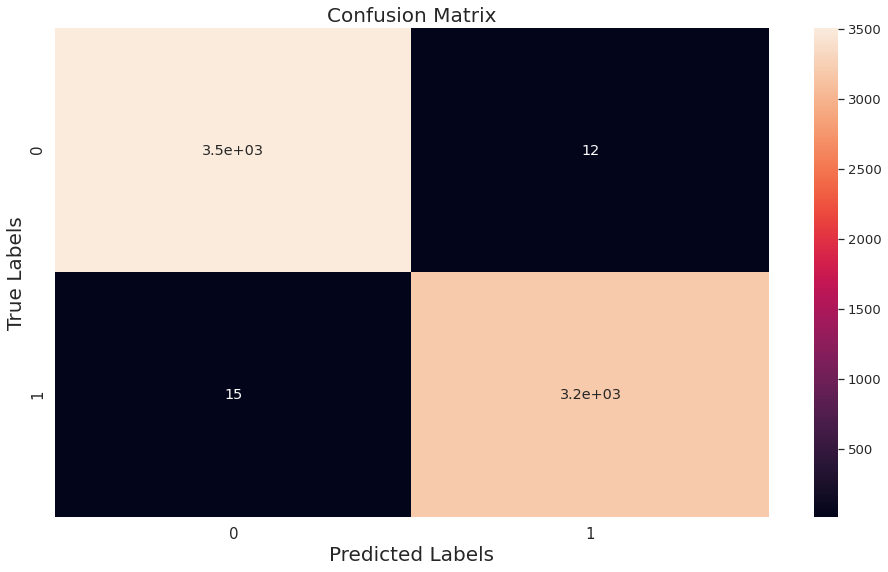

In [ ]:
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)